# Deep Q-Networks in Pytorch

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import random
from IPython.display import display, clear_output

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

#### Environments

In this notebook, we will implement DQN and run it on four environments which have a continuous state-space and discrete action-space.  There are:

 * CartPole:  Balance a pole on a moving cart (https://gym.openai.com/envs/CartPole-v1/).
 * Mountain Car:  Gather momentum to climb a hill (https://gym.openai.com/envs/MountainCar-v0/).
 * AcroBot:  A two-link robot needs to swing and reach the area above a line (https://gym.openai.com/envs/Acrobot-v1/).
 * LunarLander:  A spaceship needs to fly and land in the landing spot.  (https://gym.openai.com/envs/LunarLander-v2/).

In [ ]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'mountaincar': gym.make('MountainCar-v0'),
    'acrobot': gym.make('Acrobot-v1'),
    'lunarlander': gym.make('LunarLander-v2'),
}

These environments include a graphical visualization which we can use to visualize our learned policies.

In [ ]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    # env.render()

    while True:
        action = policy(state)
        state, _, done, _ = env.step(action)
        img.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        # env.render()

        if done:
            break

    env.close()
    clear_output(wait=True)

In [ ]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


## Misc Utilities

In [ ]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

###Exponential $\epsilon$-Greedy Decay

We will use an exponential decay, defined as
$$\epsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule.

In [ ]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        self.a = self.value_from
        self.b = np.log(self.value_to / self.value_from) / (self.num_steps - 1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """
        if step <= 0:
            value = self.value_from
        elif step >= self.num_steps -1:
            value = self.value_to
        else:
            value =  self.a * np.exp(self.b * step)

        return value


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )


_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

# Replay Memory

Now we will implement the Replay Memory, the data-structure where we store previous experiences so that we can re-sample and train on them.

In [ ]:
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        # store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`

        self.states[self.idx] = torch.tensor(state)
        self.actions[self.idx] = torch.tensor(action, dtype=torch.long)
        self.rewards[self.idx] = torch.tensor(reward)
        self.next_states[self.idx] = torch.tensor(next_state)
        self.dones[self.idx] = torch.tensor(done, dtype=torch.bool)

        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.
        # sample_size = batch_size
        if self.size < batch_size:
            batch = Batch(states=self.states,actions=self.actions,rewards=self.rewards,next_states=self.next_states,dones=self.dones)
        else:
            sample_size = batch_size
            sample_indices = random.sample(range(0, self.size), sample_size)
            batch = Batch(states=self.states[sample_indices],actions=self.actions[sample_indices],rewards=self.rewards[sample_indices],next_states=self.next_states[sample_indices],dones=self.dones[sample_indices])
        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """

        # run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        state = env.reset()
        for step in range(num_steps):
            action = random.randint(0,env.action_space.n-1)
            next_state, reward, done, _ = env.step(action)
            self.add(state, action, reward, next_state, done)
            if done:
                state = env.reset()
            else:
                state = next_state

###DQN module

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        input_dim = state_dim
        out_dim = hidden_dim
        final_output_dim = action_dim
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, out_dim))
        self.layers.append(nn.ReLU())
        input_dim = out_dim
        for layer in range(num_layers - 1):
            self.layers.append(nn.Linear(input_dim, out_dim))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(input_dim, final_output_dim))

    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """

        for layer in self.layers:
            states = layer(states)

        return states


    # utility methods for cloning and storing models
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )


dqn_model = DQN(10, 4)
_test_dqn_forward(dqn_model, (64, 10), (64, 4))
_test_dqn_forward(dqn_model, (2, 3, 10), (2, 3, 4))
del dqn_model

dqn_model = DQN(64, 16)
_test_dqn_forward(dqn_model, (64, 64), (64, 16))
_test_dqn_forward(dqn_model, (2, 3, 64), (2, 3, 16))
del dqn_model

# testing
dqn1 = DQN(10, 4, num_layers=10, hidden_dim=20)
dqn2 = DQN.custom_load(dqn1.custom_dump())
assert dqn2.state_dim == 10
assert dqn2.action_dim == 4
assert dqn2.num_layers == 10
assert dqn2.hidden_dim == 20

### Single batch-update

In [ ]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    # compute the values and target_values tensors using the
    # given models and the batch of data.
    states = batch[0]
    # print("type batch[states] = ",type(batch[0]))
    # print("type batch.states = ",type(batch.states))
    # print("shape batch[states] = ",batch[0].shape)
    # print("shape batch.states = ",batch.states.shape)
    actions = batch[1]
    rewards = batch[2]
    next_states = batch[3]
    dones = batch[4]
    cur_state_values = dqn_model(states).gather(1, actions)
    next_state_values = dqn_target(next_states).max(dim=1, keepdim=True).values
    updated_state_values = rewards + (~dones)*gamma*(next_state_values)
    updated_state_values = updated_state_values.detach()

    assert (
        cur_state_values.shape == updated_state_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # testing that the value tensor requires a gradient,
    # and the target_values tensor does not
    assert cur_state_values.requires_grad, 'values tensor should not require gradients'
    assert (
        not updated_state_values.requires_grad
    ), 'target_values tensor should require gradients'

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(cur_state_values, updated_state_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [ ]:
def epsilon_greedy_policy(state,num_actions,dqn_model,epsilon=0.1):
    if np.random.rand() <= epsilon:
        action_choice = np.random.choice(num_actions)
        return action_choice
    else:
        action_values = dqn_model(state).detach().numpy()
        # print("dqn_model(state) = ",dqn_model(state))
        # print("dqn_model(state).detach().numpy() = ",dqn_model(state).detach().numpy())
        # print("state = ",state," dqn_model(state) = ",dqn_model(state))
        # avnp = action_values.detach.numpy()
        # print("action_values = ",action_values)
        # print("action_values numpy = ",avnp)
        # for num in avnp:
        #     print(num)
        return np.argmax(action_values)

def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    We will train for a given number of time-steps rather than a given number of
    episodes.The number of time-steps will be in the range of millions, which
    still results in many episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # check that environment states are compatible with the DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # index of the current episode
    t_episode = 0  # time-step inside current episode

    state = env.reset()  # initialize state of first episode

    # pbar = tqdm.notebook.trange(num_steps, ncols='100%')
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        epsilon = exploration.value(t_total)
        action = epsilon_greedy_policy(torch.tensor(state),env.action_space.n,dqn_model,epsilon)
        next_state, reward, done, p_val = env.step(action)
        memory.add(state,action,reward,next_state,done)


        if t_total%4 == 0:
            batch = memory.sample(batch_size)
            # print("batch shape = ",batch.shape)
            loss= train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)

        if t_total%10000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())

        ...

        if done:
            G = 0
            for t in range(t_episode - 1, -1, -1):
                G = gamma*G + rewards[t]
            returns.append(G)
            lengths.append(t_episode)
            state = env.reset()
            i_episode += 1
            t_episode = 0
            rewards = []


            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {epsilon:4.2f}'
            )

            ...
        else:
            rewards.append(reward)
            state = next_state
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [ ]:
def create_plot(datalist,xlabel,ylabel,datalable,title):
    i = 0
    for data in datalist:
        plt.plot(data, label = datalable[i])
        i +=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def create_all_plots(returns,lengths,losses,envName):
    smoothened_returns = rolling_average(returns,window_size = 100)
    smoothened_lengths = rolling_average(lengths,window_size = 100)
    smoothened_losses = rolling_average(losses,window_size = 100)
    print("returns size = ",len(returns))
    print("lengths size = ",len(lengths))
    print("losses size = ",len(losses))
    print("avg len = ",np.mean(lengths))
    xlabel = "Episodes"
    ylabel = "Returns"
    title = envName + " Returns Plot"
    data_list = []
    data_list.append(returns)
    data_list.append(smoothened_returns)
    data_label = []
    data_label.append("Returns")
    data_label.append("Smoothened Returns")
    create_plot(data_list,xlabel,ylabel,data_label,title)
    ylabel = "Lengths"
    title = envName + " Lengths Plot"
    data_list = []
    data_list.append(lengths)
    data_list.append(smoothened_lengths)
    data_label = []
    data_label.append("Lengths")
    data_label.append("Smoothened Lengths")
    create_plot(data_list,xlabel,ylabel,data_label,title)
    xlabel = "Steps"
    ylabel = "Losses"
    title = envName + " Losses Plot"
    data_list = []
    data_list.append(losses)
    data_list.append(smoothened_losses)
    data_label = []
    data_label.append("Losses")
    data_label.append("Smoothened Losses")
    create_plot(data_list,xlabel,ylabel,data_label,title)

###Evaluation of DQN on the 4 environments

#### CartPole

In [ ]:
env = envs['cartpole']
gamma = 0.99

num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.01, 1_000_000)

dqn_models, cartpole_returns, cartpole_lengths, cartpole_losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

Episode: 14697 | Steps: 1 | Return: 21.43 | Epsilon: 0.01: 100%|██████████| 1500000/1500000 [13:45<00:00, 1817.32it/s] 


returns size =  17801
lengths size =  17801
losses size =  375000
avg len =  83.25931127464749


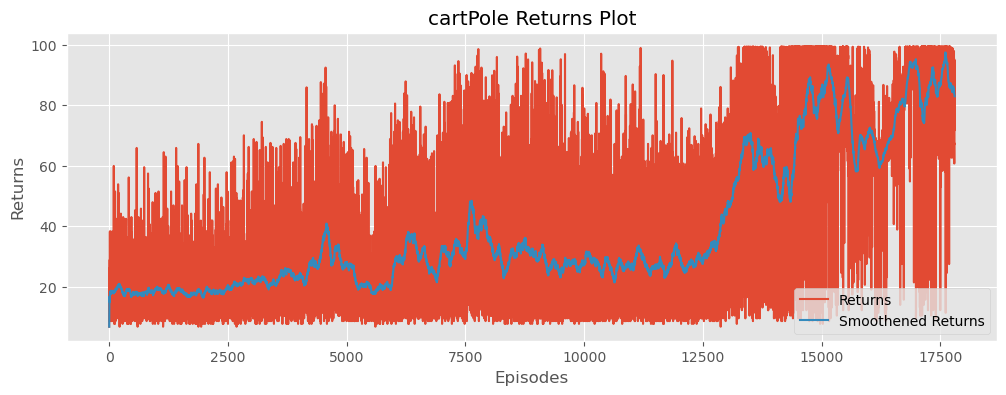

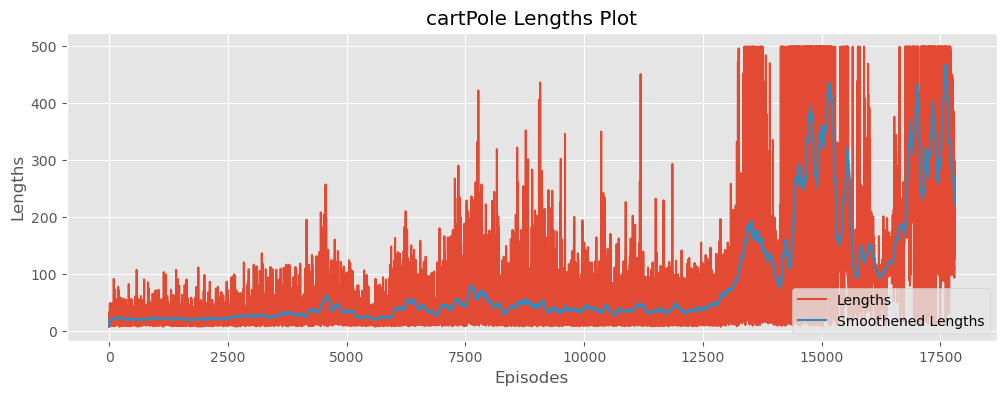

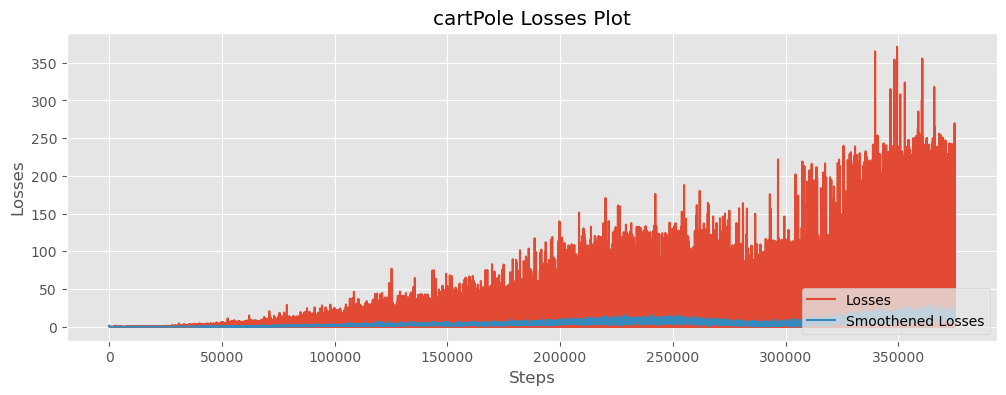

In [ ]:
create_all_plots(cartpole_returns,cartpole_lengths,cartpole_losses,"cartPole")

#### MountainCar

In [ ]:
env = envs['mountaincar']
gamma = 0.99


num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.01, 1_000_000)

dqn_models, mountaincar_returns, mountaincar_lengths, mountaincar_losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

Episode: 9998 | Steps: 1 | Return: -66.22 | Epsilon: 0.01: 100%|██████████| 1500000/1500000 [12:01<00:00, 2078.63it/s]


returns size =  9998
lengths size =  9998
losses size =  375000
avg len =  149.02830566113224


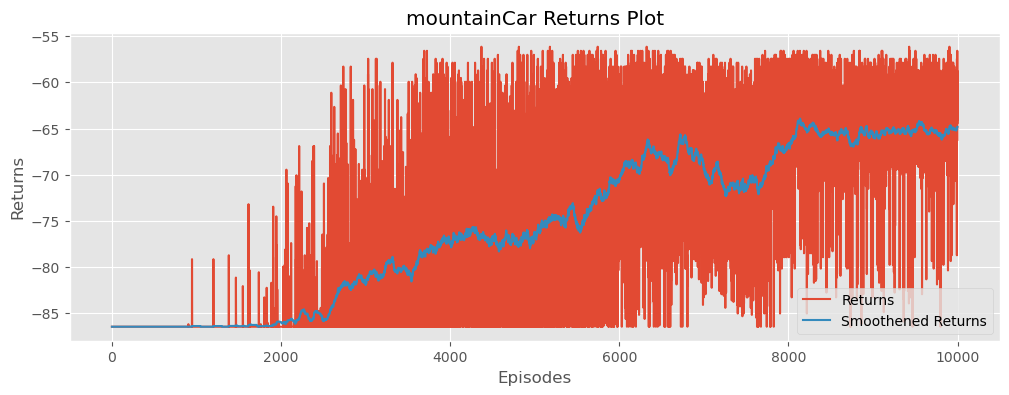

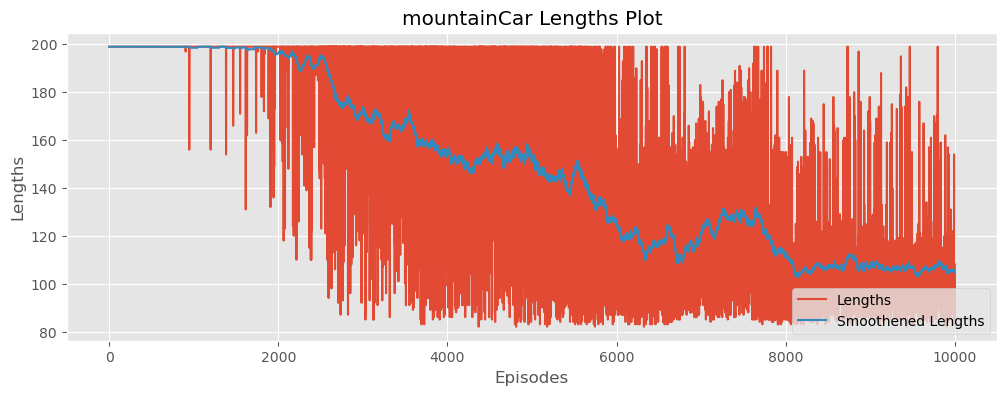

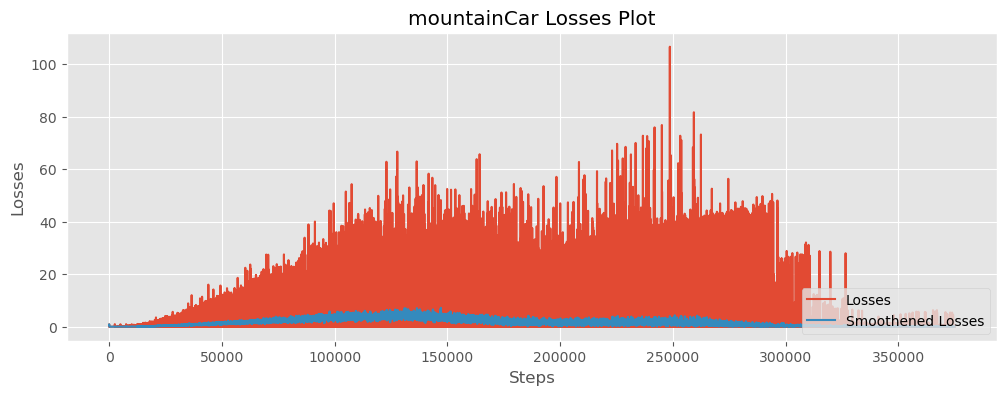

In [ ]:
create_all_plots(mountaincar_returns,mountaincar_lengths,mountaincar_losses,"mountainCar")

#### AcroBot

In [ ]:
env = envs['acrobot']
gamma = 0.99

num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.01, 1_000_000)

dqn_models, acrobot_returns, acrobot_lengths, acrobot_losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

Episode: 12573 | Steps: 1 | Return: -46.37 | Epsilon: 0.01: 100%|██████████| 1500000/1500000 [12:27<00:00, 2007.80it/s]


returns size =  12573
lengths size =  12573
losses size =  375000
avg len =  118.30112145072775


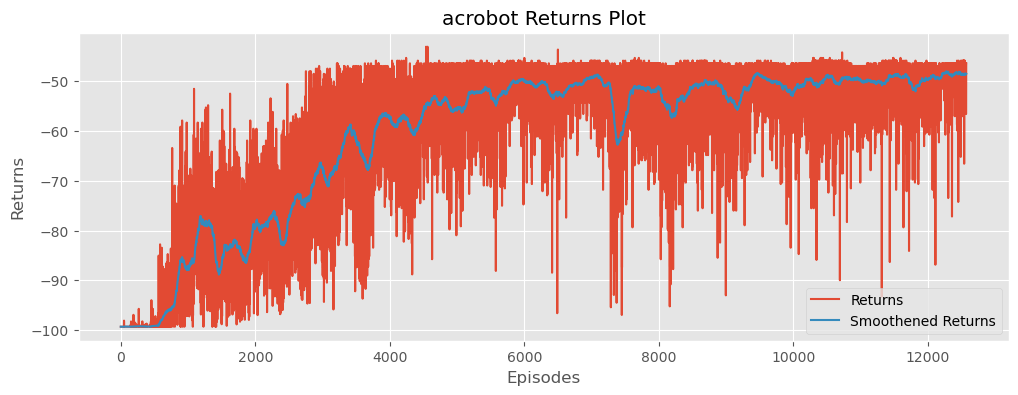

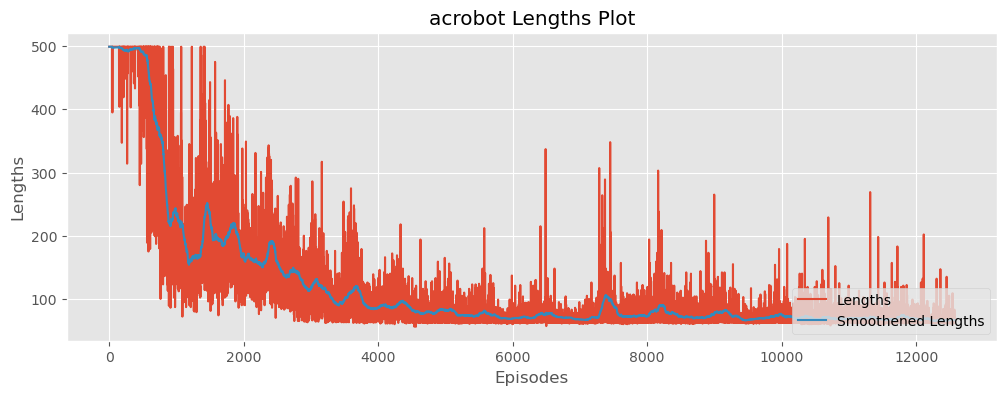

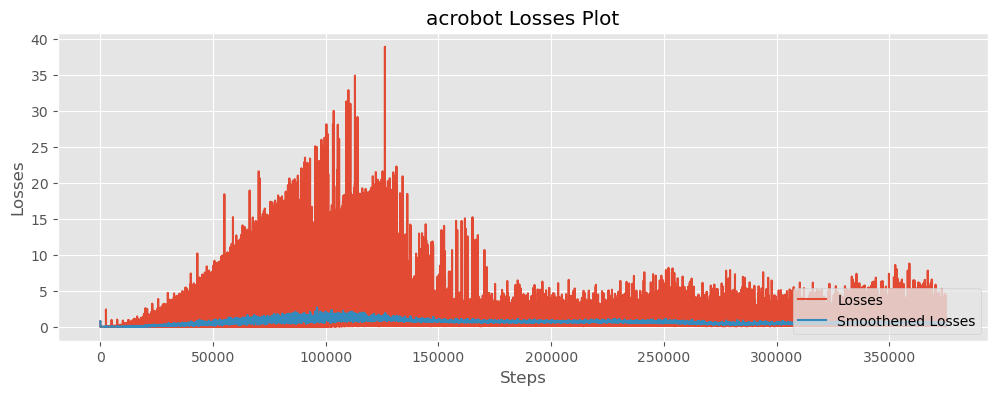

In [ ]:
create_all_plots(acrobot_returns,acrobot_lengths,acrobot_losses,"acrobot")

#### LunarLander

In [ ]:
env = envs['lunarlander']
gamma = 0.99

num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.01, 1_000_000)

dqn_models, lunarlander_returns, lunarlander_lengths, lunarlander_losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

Episode: 5671 | Steps: 1 | Return: 44.86 | Epsilon: 0.01: 100%|██████████| 1500000/1500000 [48:14<00:00, 518.21it/s]   


returns size =  5671
lengths size =  5671
losses size =  375000
avg len =  263.4946217598307


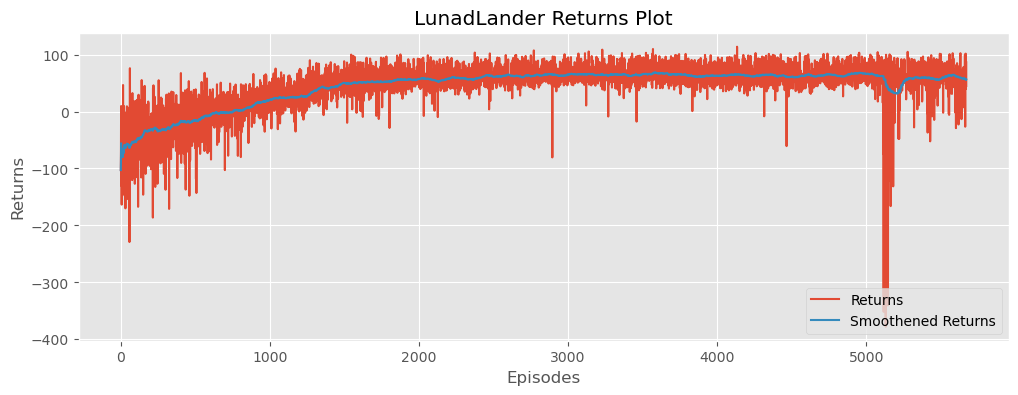

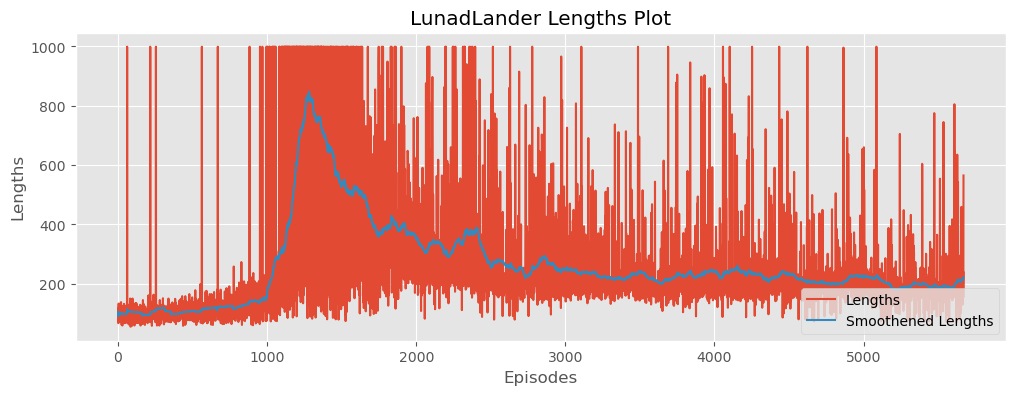

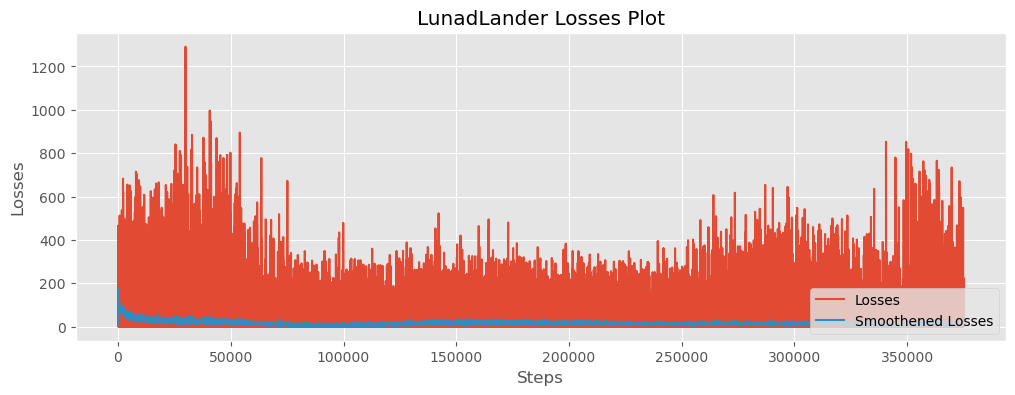

In [ ]:
create_all_plots(lunarlander_returns,lunarlander_lengths,lunarlander_losses,"LunadLander")

### Visualization of the trained policies!

Run the cell below and push the buttons to view the progress of the policy trained using DQN.

In [ ]:
buttons_all = []
for key_env, env in envs.items():
    try:
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)

            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True

                    render(env, lambda state: dqn(torch.tensor(state, dtype=torch.float)).argmax().item())

                    for b in buttons_all:
                        b.disabled = False

                return button_callback

            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)

        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)

cartpole:


mountaincar:


acrobot:


lunarlander:


### Analysis

For each environment, below I have described the progress of the training in terms of the behavior of the agent at each of the 5 phases of training (i.e. 0%, 25%, 50%, 75%, 100%).  

##### CartPole

* 0% - Here, the cartpole is randomly moving and hence we can see that it goes out of balance very quickly.

* 25% - We can see that its performing much better than when it used to perform at 0% because it has trained well to balance the pole for some time. however, it balances for very little steps and also most of the times goes out of balance in few steps.

* 50% - At this stage, it balances the pole for longer time than before and manages to balance moving on both sides.

* 75% - At this stage also it performs similar to 50% but balances for more time on average comapred to 50% stage.

* 100% - Most of the times, it balances for very long time and ideally also, the goal of this env is to balance the cartpole as long as possible(max 500 steps). Even from the training plot, we can observe that at the end, the episode lengths are almost 500 whihc is almost the ideal scenario. However, for some trial I did run, it stop soon either by going to the edge of the box.

##### MountainCar

* 0% - When its not trained, it simply be there most of the time at its initial position, moving randomly to and for. It just keeps moving little unable to move up unitl it reaches the maximum steps.

* 25% - At this stage also, it has not learnt much as it keeps moving to and for but not reaching the goal position most of the times. I have run it lot of times and didnt see it reach the goal. It moves to and fro until it has reached max time steps and stops. Its trying to learn to reach the goal but has not yet learnt.

* 50% - At this stage, it reaches the goal most of the times as it has learnt to reach the goal. But its doesnt do it in the best time steps as it takes some time to reach the step. Ex: sometimes, it moves forward first, and goes back and eventuallly goes forward to reach the goal.
* 75% - At this stage, it has mostly learnt to efficiently reach the goal and I can see that most of the times, it reaches the goal in min time steps. However, very few times, it takes little more time steps to reach the goal.

* 100% - At this stage also, it reaches the goal in min time steps and the optimal behaviour is also to reach the goal in minimum time steps and we can see that it has acheived it. We can also see from the plot that, it takes minimum time steps to reach the goal compared to other stages of the training phase.

##### Acrobot

* 0% - random torques are actuated at both joints and hence just keep moving without touching the target height. It stops when it recahes 500 time steps without reaching the terget height.

* 25% - At this stage it is still trying to learn and has not yet learnt to reach the required height. Most of the times, it reaches 500 time steps without reaching the target height. There is no much difference in results compared to 0% stage.

* 50% - At 50% stage, it does little better than 25% stage. Here also, most of the times it doesnt reach the target height. But few times it does reach the goal height. However, even when it reaches the required height, it takes more time to reach the height.

* 75% - At this stage, we can clearly see that the free end hits the target height most of the times and also take very less steps to reach the required height. It does much better than how it did at 25% and 50% stage.

* 100% - the acrobot free end reaches the target height in the least steps considered to other stages we have seen. Optimally, acrobat free end has to reach the target height in minimum time steps and I think at 100% of our training model, most of the times, it performs optimally. However, in very less cases, it doesnt reach the target height may be because it took the wrong step at some point and couldnt recover from it.

##### LunarLander

* 0% - Here, we can see that the lonarLander simply randomly comes down and falls somewhere as it has not learnt to land properly.

* 25% - At this stage, we can see that its trying to land properly, but takes lot of time to land. However, some time sit doesnt land properly and crashes or is not awake. We can also see from the plot that, the episode lengths are very long during this stage of the trainig.

* 50% - We can observe that it does much better than at 25% as it lands much faster than the time it was taking at 25%. However, it still takes more time but most of the time it lands between the two flags.

* 75% - At this stage also it performs similar to how it was performing at 50% and lands most of the times in the given location and takes almost same time steps.

* 100% - At this stage also, it performs similar to how it was performing at stage 50% and 75%. Optimally, it has to land on the landing pad and come to rest efficiently. I think this is acheived at around 50-70% of the stage and can effectively land in the landing pad.